In [1]:
from aae import aae_model
from tools import MinMaxScaler, DiscrMonitor
from evaluation_model import disc_eva, fore_eva
from networks import timesformer_dec, cnn_enc, cnn_dec, cautrans_dec, discriminator
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from sklearn.model_selection import train_test_split
import scipy.stats

## Prepare data

In [2]:
dataset = 'sine_cpx'            #use Sine_cpx as an example  
valid_perc = 0.1
train_perc = 1-valid_perc
full_train_data = np.load('datasets/'+dataset+'.npy')
N, T, D = full_train_data.shape

In [3]:
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train
np.random.shuffle(full_train_data)
train_data = full_train_data[:N_train]
valid_data = full_train_data[N_train:]
scaler = MinMaxScaler()        
x_train = scaler.fit_transform(train_data)
x_valid = scaler.transform(valid_data)

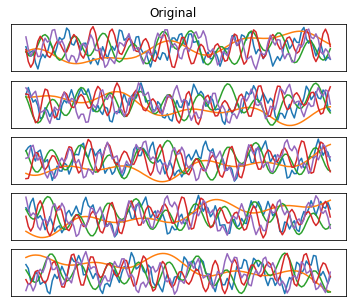

In [4]:
fig, axs = plt.subplots(5, 1, figsize=(6,5), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(x_train))
    s = x_train[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Original')
st.set_y(0.93)

## Build model

In [5]:
ts_shape = x_train.shape[1:]
latent = 16

In [6]:
enc = cnn_enc(
    input_shape=ts_shape,
    latent_dim=latent,
    n_filters=[64, 128, 256],
    k_size=4,
    dropout=0.2
)

dec = timesformer_dec(
    input_shape=latent,
    ts_shape=ts_shape,
    head_size=64,
    num_heads=3,
    n_filters=[128, 64],
    k_size=4,
    dilations=[1,4],
    dropout=0.2
)

disc = discriminator(input_shape=latent, hidden_unit=32)

In [7]:
def ae_loss(ori_ts, rec_ts):
    return tf.keras.metrics.mse(ori_ts, rec_ts)

def dis_loss(y_true, y_pred):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

def gen_loss(y_true, y_pred):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

In [8]:
ae_schedule = PolynomialDecay(initial_learning_rate=0.005, decay_steps=300, end_learning_rate=0.0001, power=0.5)
dc_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.0001, power=0.5)
ge_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.0001, power=0.5)

In [9]:
ae_opt = tf.keras.optimizers.Adam(ae_schedule)
dc_opt = tf.keras.optimizers.Adam(dc_schedule)
ge_opt = tf.keras.optimizers.Adam(ge_schedule)

In [10]:
model = aae_model(
    encoder=enc, 
    decoder=dec, 
    discriminator=disc, 
    latent_dim=latent, 
    dis_steps=1,
    gen_steps=1)

In [11]:
model.compile(rec_opt=ae_opt, rec_obj=ae_loss, dis_opt=dc_opt, dis_obj=dis_loss, gen_opt=ge_opt, gen_obj=gen_loss)

## Train model
#### We provide pre-trained model weights here, you are welcome to change the parameters and play with it. 

In [12]:
model.load_weights('save_model/sine_cpx/aae_ckp') #pre_trained model, to reproduce similar results as paper

In [ ]:
history = model.fit(x_train, epochs=800, batch_size=128) #you can train the model from the start here 

In [13]:
z = tf.random.normal([x_train.shape[0], latent], 0.0, 1.0)
sample = model.dec.predict(z)

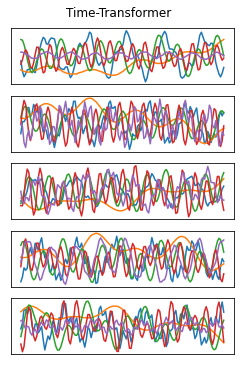

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(4,6), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(sample))
    s = sample[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Time-Transformer')
st.set_y(0.93)

## Visualization

In [15]:
train_ori = np.mean(x_train, axis=-1)
train_gen = np.mean(sample, axis=-1)

In [16]:
select = x_train.shape[0]
idx = np.random.permutation(select)
ori = train_ori[idx]
gen = train_gen[idx]
prep_data_final = np.concatenate((ori, gen), axis = 0)

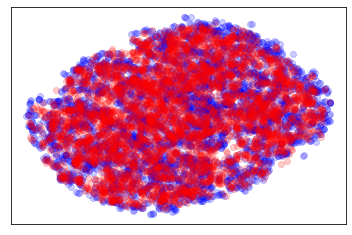

In [17]:
emb = TSNE(n_components=2, learning_rate=10, init = 'random', perplexity=50, n_iter=400).fit_transform(prep_data_final)
plt.yticks([])
plt.xticks([])
plt.scatter(emb[:select, 0], emb[:select, 1], alpha=0.2, color='b')
plt.scatter(emb[select:, 0], emb[select:, 1], alpha=0.2, color='r')

## Discriminative Score

In [18]:
res_d = []
for _ in range(5):  # run 5 times to calculate avg and CI
    x_train_d = np.concatenate((x_train, sample))
    y_train_d = np.append(np.ones(x_train.shape[0]), np.zeros(sample.shape[0]))
    disc_m = disc_eva(input_shape=x_train_d.shape[1:], rnn_unit=[128], dropout=0.3)
    disc_m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    disc_m.fit(x_train_d, y_train_d, epochs=200, batch_size=128, verbose=0)
    
    test_gen = model.dec.predict(tf.random.normal([N_valid, latent], 0.0, 1.0))
    test_ori = x_valid
    x_test_d = np.concatenate((test_ori, test_gen))
    y_test_d = np.append(np.ones(test_ori.shape[0]), np.zeros(test_gen.shape[0]))
    l, acc = disc_m.evaluate(x_test_d, y_test_d)
    res_d.append(np.abs(acc-0.5))
    
print("Max:{}, Min:{}, Avg:{}".format(np.max(res_d), np.min(res_d), np.mean(res_d)))

32/32 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5010
Max:0.16500002145767212, Min:0.0009999871253967285, Avg:0.06339999437332153


In [19]:
se = scipy.stats.sem(res_d)
se*scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)

0.0797502346657076

## Predictive Score

In [20]:
def forecast_data(x): #prepare forecast data
    x = x[:, :-1, :]
    y = x[:, -1, :]
    return x, y

In [21]:
res = []
for _ in range(5): # run 5 times to calculate avg and CI
    x_train_p, y_train_p = forecast_data(sample) # Train on synthetic
    x_test, y_test = forecast_data(x_train) # Test on real
    fore = fore_eva(input_shape=x_train_p.shape[1:], out_shape=x_train_p.shape[-1], rnn_unit=[128])
    fore.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
    fore.fit(x_train_p, y_train_p, epochs=200, batch_size=128, verbose=0)
    res.append(fore.evaluate(x_test, y_test))
print(np.max(res), np.min(res), np.mean(res))

141/141 [==============================] - 1s 4ms/step - loss: 0.0014
0.0027397854719311 0.0013647329760715365 0.0022177611943334343


In [22]:
se = scipy.stats.sem(res)
se*scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)

0.0007560942036818392

## Save generated data

In [23]:
np.save('save_model/gen_'+dataset+'.npy', sample)